# Motivation

The purpose of this notebook is to introduce a simpler method but with the same results or similar to extract the 98 TFs

In [109]:
%load_ext autoreload
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
import sys

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import multiprocess as mp


# own libraries
sys.path.append('/Users/vlad/Documents/Code/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities import clustering as cs
from NetworkAnalysis.utilities import sankey_consensus_plot as sky
from NetworkAnalysis.utilities.helpers import save_fig, survival_plot
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
from NetworkAnalysis.dea import dea
from NetworkAnalysis.dea import helpers as dea_hp
from NetworkAnalysis.dea import gsea as gsea_hp
sys.path.append(os.path.dirname("../../src"))
# Gsea libraries

pio.templates.default = "ggplot2"

pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/"
exp_folder_tumour = "network_I/tum/"  # "/integration_v2.1/ - path from iNET


# Experiments set
exp_folder_h42 = "network_I/healthy42/"
exp_folder_h42_ctrl = "network_I/healthyControls/"


figures_path = "./sel_pruning_v2/"

vu_output = pd.read_csv(f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index("gene")

tum_tpms = pd.read_csv(f"{data_base}/tumour/TPMs_selected_genes_v3_13k_gc42.tsv", sep="\t", index_col="genes")
tum_tpms_v4 = pd.read_csv(f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")

# Healthy and metadata
healthy_metadata = pd.read_csv(f"{data_base}/non_cancerous/healthy_bladder_metadata.tsv", sep="\t", index_col="Sample").drop(index=["Y2796_P0"])
healthy_metadata["sample_prcsd"] = healthy_metadata.index.str.replace("-", "_")

healthy_tpm = pd.read_csv(f"{data_base}/non_cancerous/healthy_data_all_gc42_v4.tsv", sep="\t", index_col="gene")
remap_col = {}
for col in healthy_tpm.columns:
    remap_col[col] = col.replace("-", "_")
healthy_tpm = healthy_tpm.rename(columns=remap_col)

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t", skip_header=1, dtype="str")

In [111]:
# Base-line, this is the results from previous work
sel_tfs = pd.read_csv(f"{data_base}/tf_ctrl_v2.tsv", index_col="gene", sep="\t")
sel_tfs["tum_mean_expression"] = tum_tpms_v4.loc[sel_tfs.index].mean(axis=1)
sel_tfs["tum_median_expression"] = tum_tpms_v4.loc[sel_tfs.index].median(axis=1)
sel_tfs["tum_std_expression"] = tum_tpms_v4.loc[sel_tfs.index].std(axis=1)
sel_tfs["tum_var_expression"] = tum_tpms_v4.loc[sel_tfs.index].var(axis=1)

## Import the data

## Experiment sets

In [112]:
def load_experiment_set(base_path, exp_folder_path):
    exp_path = f"{base_path}/{exp_folder_path}/Stats/"
    meta_files = next(os.walk(exp_path), (None, None, []))[2]
    # keep only the network stats
    files = [file for file in meta_files if "networkStats" in file]
    exp_set = {}
    for file in files:
        exp = file.replace(".tsv", "").replace("networkStats_standard_int_", "")
        exp_set[exp] = pd.read_csv(f"{exp_path}/{file}", index_col="gene", sep="\t")
    return exp_set

In [113]:
folders = next(os.walk(base_path + exp_folder_h42_ctrl), (None, None, []))[1]
exp_ctrls = {}
for folder in folders:
    hCtrl_path = f"/{exp_folder_h42_ctrl}/{folder}/"
    meta_files = next(os.walk(hCtrl_path), (None, None, []))[2]
    # keep only the network stats
    files = [file for file in meta_files if "networkStats" in file]
    exp_ctrls[folder] = load_experiment_set(base_path, hCtrl_path)

exp_set = load_experiment_set(base_path, exp_folder_h42)

## Network stats

Information calculated in the selective edge pruning

In [114]:
def merge_metrics(exp_set: dict, exp_type: str):
    comb_df = pd.DataFrame()
    for key, metrics in exp_set.items():
        metrics["TF"] = int(key.split("_")[-1].replace("TF", ""))
        metrics["Type"] = exp_type
        comb_df = pd.concat([comb_df, metrics], axis=0)

    return comb_df


# Experiments
all_exps = merge_metrics(exp_set=exp_set, exp_type="Exp")
all_exps["isCtrl"] = False

# Ctrls
all_ctrls = pd.DataFrame()
for key, value in exp_ctrls.items():
    label = key.split("h")[-1]
    ctrl_exps = merge_metrics(exp_set=value, exp_type=key)
    ctrl_exps["isCtrl"] = True
    all_ctrls = pd.concat([all_ctrls, ctrl_exps], axis=0)

# Combined
comb_exps = pd.concat([all_exps, all_ctrls], axis=0)


sel_tfs_metrics = comb_exps.loc[comb_exps.index.isin(sel_tfs.index)].copy(deep=True)
# sel_tfs_metrics = comb_exps

reorder_cols = [
    "degree_w",
    "degree_t",
    "degree_i",
    "degree_o",
    "pageRank",
    "closeness",
    "katz",
    "hits",
    "central_point_dominance",
    "max_b",
    "TF",
    "betweenness",
    "marked_as_tf",
    "mut_count",
    "Type",
    "isCtrl",
    "ModCon_Rank",
]
sel_tfs_metrics = sel_tfs_metrics[reorder_cols]
comb_exps = comb_exps[reorder_cols]

# Correlations between the metrics

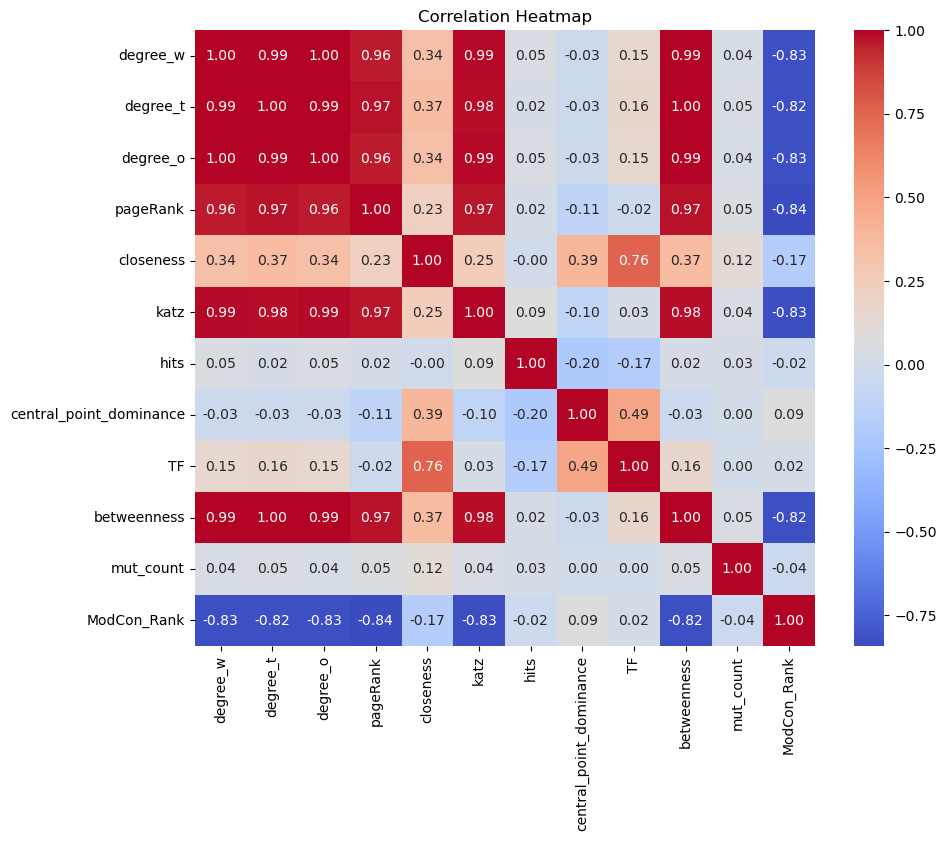

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = sel_tfs_metrics.drop(
    columns=[
        "Type",
        "isCtrl",
        "degree_i",
        "marked_as_tf",
        "max_b",
    ]
).corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")

plt.savefig(f"{figures_path}/sel_tfs_corr_heatmap.png")

plt.show()

# Matching with the 98 TFs

## Selection by degree

In [232]:
def calculate_degree_thresholds(exp_set: dict, sel_tfs: pd.DataFrame, label: str, q_th=0.75, verbose=False):
    sel_genes = set()
    exp_ths = []
    for exp, metrics in exp_set.items():
        deg_th = metrics["degree_t"].quantile(q=q_th)
        genes = metrics[metrics["degree_t"] >= deg_th].index
        if len(sel_genes):
            sel_genes = set(genes) & sel_genes
        else:
            sel_genes = set(genes)

        prscsd_label = int(exp.split("_")[-1].replace("TF", ""))
        exp_ths.append((prscsd_label, deg_th))

    if sel_tfs.empty:
        matched = sel_genes
    else:
        matched = sel_genes & set(sel_tfs.index)

    if verbose:
        print(f"--> {label}\n\tQ_th: {q_th}. Matched genes with 98 TFs {len(matched)}")

    dmy = pd.DataFrame(exp_ths, columns=["TF", "Degree_th"])
    dmy = dmy.sort_values(by=["TF"], ascending=True)
    dmy["TF"] = dmy["TF"].astype(str)
    fig = px.bar(dmy, x="TF", y="Degree_th", text_auto=True, title=f"Q_th: {q_th}. For {label}")

    return matched, fig


results_qth = {}
q_ths = list(range(4, 10, 1))
q_ths.append(7.5)
stats = [(0, 98)]  # default values
for q_th in q_ths:
    q_th = q_th / 10
    matched_exp, fig_exp = calculate_degree_thresholds(exp_set=exp_set, sel_tfs=sel_tfs, label="Exp", q_th=q_th, verbose=False)

    matched_ctrls = {}
    common_ctrls = set()
    for key, value in exp_ctrls.items():
        label = key.split("h")[-1]
        matched_ctrl, fig_ctrl = calculate_degree_thresholds(exp_set=value, sel_tfs=sel_tfs, label=label, q_th=q_th, verbose=False)
        matched_ctrls[key] = {"matched": matched_ctrls, "fig": fig_ctrl}

        if len(common_ctrls):
            common_ctrls = common_ctrls & set(matched_ctrl)
        else:
            common_ctrls = matched_ctrl

    print(f"### Q {q_th}. Matched genes across controls {len(common_ctrls)}")

    matched_overall = set(matched_exp) & set(common_ctrls)
    results_qth[q_th] = list(matched_overall)
    stats.append((q_th, len(matched_overall)))
    print(f"### Overall matched (ctrls & exps) {len(matched_overall)}")

stats = pd.DataFrame(stats, columns=["Quantile", "Matched"])
stats.sort_values(by="Quantile", ascending=True, inplace=True)
stats["Quantile"] = stats["Quantile"].astype(str)

px.bar(stats, x="Quantile", y="Matched", text_auto=True)

### Q 0.4. Matched genes across controls 98
### Overall matched (ctrls & exps) 98
### Q 0.5. Matched genes across controls 94
### Overall matched (ctrls & exps) 94
### Q 0.6. Matched genes across controls 91
### Overall matched (ctrls & exps) 91
### Q 0.7. Matched genes across controls 74
### Overall matched (ctrls & exps) 74
### Q 0.8. Matched genes across controls 48
### Overall matched (ctrls & exps) 48
### Q 0.9. Matched genes across controls 15
### Overall matched (ctrls & exps) 15
### Q 0.75. Matched genes across controls 60
### Overall matched (ctrls & exps) 60


## Check where the genes are on the DEA work

For `q=75` there are 60 genes matched

In [178]:
def plot_dea_results(f_absCa_p0, f_absCa_ud, dea_path, sel_tfs, markers_var, display_quadrant=False, th=0.05):

    # It needs to be ther order of the quadrants
    axis_order = ["AbsCa", "AbsCa", "UD", "P0"]
    text_color = "#003366"

    pi, pi_df = dea.plotPi(f_absCa_p0, f_absCa_ud, base_path=dea_path, known_markers=False, markers=markers_var)
    pi, core_bladder = dea.add_box_core(pi, pi_df, subset=sel_tfs, th=0.05, display=True)
    pi = dea_hp.toggle_legend(pi, kept_traces=markers_var.keys())
    pi.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            xanchor="center",
            y=0.92,
            x=0.3,
            bgcolor="rgba(0,0,0,0)",
            font=dict(size=18, color=text_color),
        ),
        template="ggplot2",
        font_size=14,
        xaxis=dict(tickmode="linear", tick0=0, dtick=25, tickfont=dict(size=16), title_font_size=22, title_text="P0 vs Abs-Ca"),
        yaxis=dict(tickmode="linear", tick0=0, dtick=25, tickfont=dict(size=16), title_font_size=22, title_text="Abs-Ca vs UD"),
        height=1000,
        xaxis_range=[-225, 75],
        yaxis_range=[-75, 160],
    )

    pi.add_annotation(text="ABS-Ca", x=0, y=150, showarrow=False, font=dict(size=22, color=text_color))
    pi.add_annotation(text="UD", x=0, y=-70, showarrow=False, font=dict(size=22, color=text_color))
    pi.add_annotation(text="P0", x=-220, y=0, showarrow=False, font=dict(size=22, color=text_color))
    pi.add_annotation(text="ABS-Ca", x=65, y=0, showarrow=False, font=dict(size=22, color=text_color))

    sel_df = pi_df[pi_df.index.isin(sel_tfs.index)]

    axis_specific, quadrant_df = pd.DataFrame(), pd.DataFrame()
    min_x, max_x = pi_df["x"].min(), pi_df["x"].max()
    min_y, max_y = pi_df["y"].min(), pi_df["y"].max()
    x_neg, x_pos = min_x * th, max_x * th
    y_neg, y_pos = min_y * th, max_y * th

    rectangles = [
        dict(type="rect", x1=x_pos, y1=max_y + 50, x0=x_neg, y0=0, line=dict(color="black", width=1), layer="below", fillcolor="yellow"),
        dict(type="rect", x1=max_x + 50, y1=y_pos, x0=0, y0=y_neg, line=dict(color="black", width=1), layer="below"),
        dict(type="rect", x0=x_neg, y0=min_y, x1=x_pos, y1=0, line=dict(color="black", width=1), layer="below", fillcolor="blue"),
        dict(type="rect", x0=min_x, y0=y_neg, x1=0, y1=y_pos, line=dict(color="black", width=1), layer="below", fillcolor="orange"),
    ]
    quadrant = [
        dict(type="rect", x0=x_pos, y0=y_pos, x1=max_x, y1=max_y, line=dict(color="black", width=1), layer="below", fillcolor="blue"),
        dict(type="rect", x1=max_x, y1=y_neg, x0=x_pos, y0=min_y, line=dict(color="black", width=1), layer="below", fillcolor="purple"),
        dict(type="rect", x1=x_neg, y1=y_neg, x0=min_x, y0=min_y, line=dict(color="black", width=1), layer="below", fillcolor="red"),
        dict(type="rect", x0=min_x, y0=y_pos, x1=x_pos, y1=max_y, line=dict(color="black", width=1), layer="below", fillcolor="magenta"),
    ]

    for idx, rect in enumerate(rectangles):
        pi.add_shape(**rect)
        inside_df = dea_hp.filter_points_in_rectangle(sel_df, rect)
        inside_df["label"] = axis_order[idx]
        axis_specific = pd.concat([axis_specific, inside_df], axis=0)

    for idx, rect in enumerate(quadrant):
        if display_quadrant:
            pi.add_shape(**rect)
        inside_df = dea_hp.filter_points_in_rectangle(sel_df, rect)
        subtype = f"{axis_order[idx]}-{axis_order[(idx+1) % (len(axis_order))]}"
        inside_df["label"] = subtype
        quadrant_df = pd.concat([quadrant_df, inside_df], axis=0)

    pi.add_scatter(
        x=[pi_df["x"].max()],
        y=[pi_df["y"].max()],
        marker_symbol="x-thin",
        marker_line_color="lightskyblue",
        marker_line_width=4,
        marker_size=15,
        mode="markers+text",
        showlegend=False,
        text=["Ref point"],
        textposition="bottom center",
    )

    pi.update_traces(marker=dict(size=14, opacity=0.6), selector=dict(mode="markers"))
    pi.show()


f_absCa_p0 = "sleuth_ABS-Ca_P0_v4_vulcano_labels.tsv"
f_ud_p0 = "sleuth_UD_P0_v4_vulcano_labels.tsv"
f_absCa_ud = "sleuth_ABS-Ca_UD_v4_vulcano_labels.tsv"

dea_path = f"{data_base}/non_cancerous/dea/"

In [179]:
#### Values taken frpm selectr_ctrl_tf.ipynb from the thesis experiments.,
core_bladder = [
    "TGIF1",
    "PLSCR1",
    "AHR",
    "SAFB2",
    "CIC",
    "MBD6",
    "POGK",
    "ZNF524",
    "SPEN",
    "IRF7",
    "ELF4",
    "ZNF513",
    "FBXL19",
    "SP110",
    "TCF20",
    "KMT2A",
    "ZNF846",
    "ZNF335",
    "ZNF276",
    "ZNF211",
    "HIVEP2",
    "DOT1L",
    "MAFG",
    "ELK4",
    "HIVEP1",
    "ZNF609",
    "LCOR",
    "TRERF1",
    "NFAT5",
    "ZBTB21",
]
markers_var = {
    "98 TFs": list(sel_tfs.index),
    "tum only": list(sel_tfs[sel_tfs["Type"] == "Tum"].index),
    "non-tum only": list(sel_tfs[sel_tfs["Type"] == "Healthy"].index),
    "both": list(sel_tfs[sel_tfs["Type"] == "Both"].index),
}

used_markers = {
    **markers_var,
    **results_qth,
}

In [180]:
# Example usage:
plot_dea_results(f_absCa_p0, f_absCa_ud, dea_path, sel_tfs, used_markers)

# Without matching

Find the genes common without the restrictions of the 98 TFs

In [208]:
results_qth = {}
q_th = 0.9
matched_exp, fig_exp = calculate_degree_thresholds(exp_set=exp_set, sel_tfs=pd.DataFrame(), label="Exp", q_th=q_th, verbose=False)

matched_ctrls = {}
common_ctrls = set()
for key, value in exp_ctrls.items():
    label = key.split("h")[-1]
    matched_ctrl, fig_ctrl = calculate_degree_thresholds(exp_set=value, sel_tfs=pd.DataFrame(), label=label, q_th=q_th, verbose=False)
    matched_ctrls[key] = {"matched": matched_ctrls, "fig": fig_ctrl}

    if len(common_ctrls):
        common_ctrls = common_ctrls & set(matched_ctrl)
    else:
        common_ctrls = matched_ctrl

print(f"### Q {q_th}. Matched genes across controls {len(common_ctrls)}")

matched_overall = set(matched_exp) & set(common_ctrls)
results_qth[q_th] = list(matched_overall)
print(f"### Overall matched (ctrls & exps) {len(matched_overall)}")

### Q 0.9. Matched genes across controls 151
### Overall matched (ctrls & exps) 149


In [209]:
# tpm_sel = tum_tpms_v4.loc[list(matched_overall)]
len(set(tf_list) & set(matched_overall))

15